Loaded 6 fronts from: ..\isocontours
Isolevels: [3.0, 3.5, 4.4, 4.5, 4.6, 4.7]
KMeans: 3 on ['curvature', 'tangential_strain_rate', 'normal_strain_rate']
PCA mode: auto
PCA excluded (auto): {'y', 'x', 'z', 'omega_N2', 'N2', 'c_iso'}


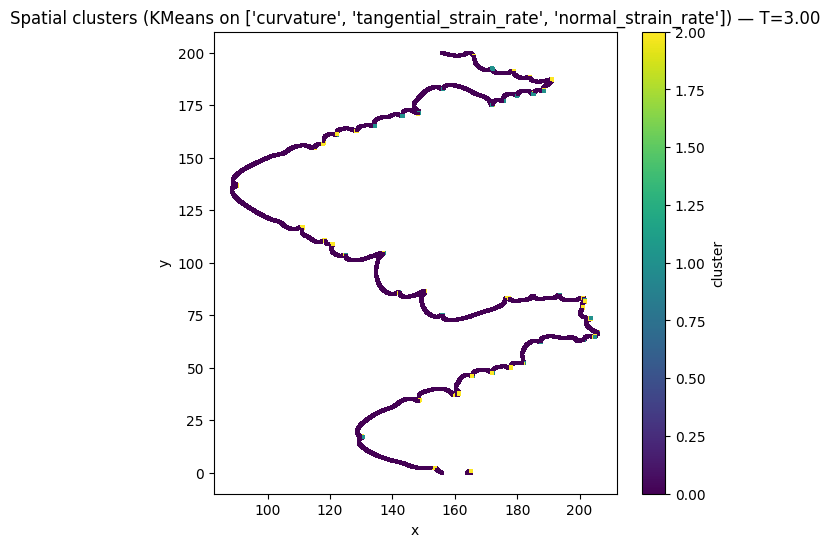

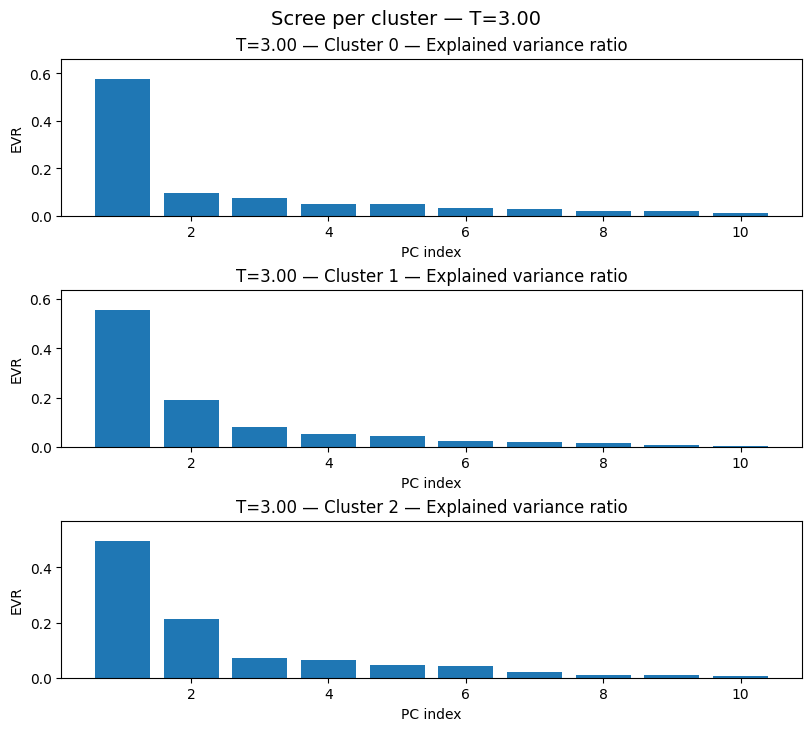

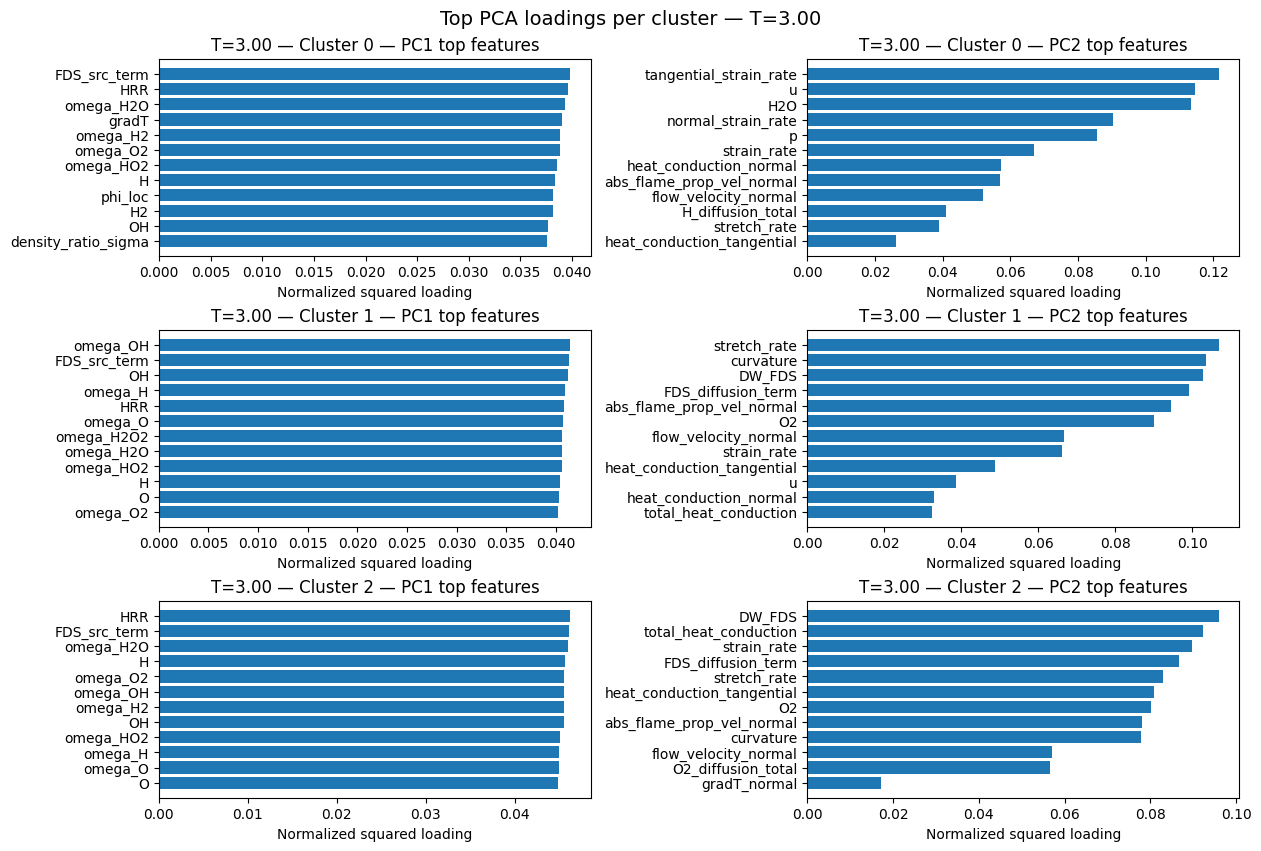

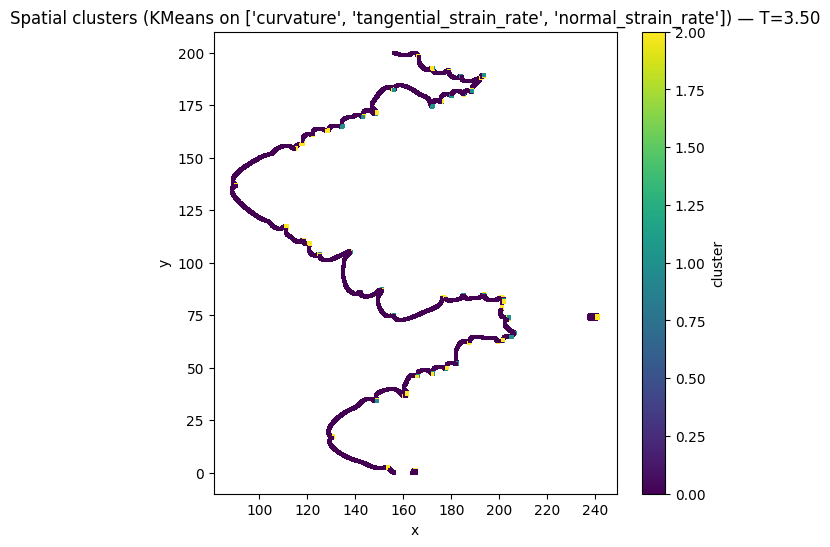

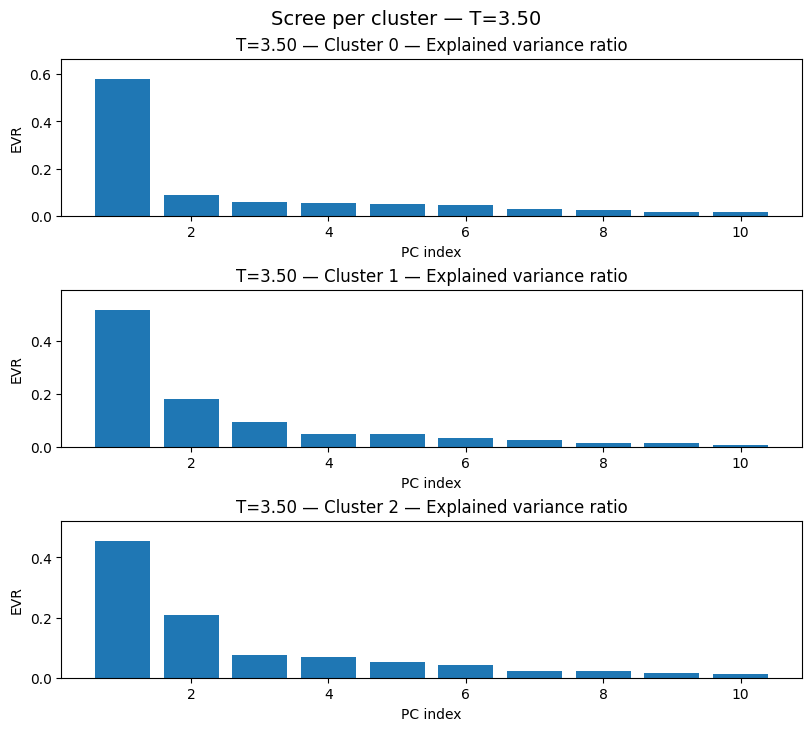

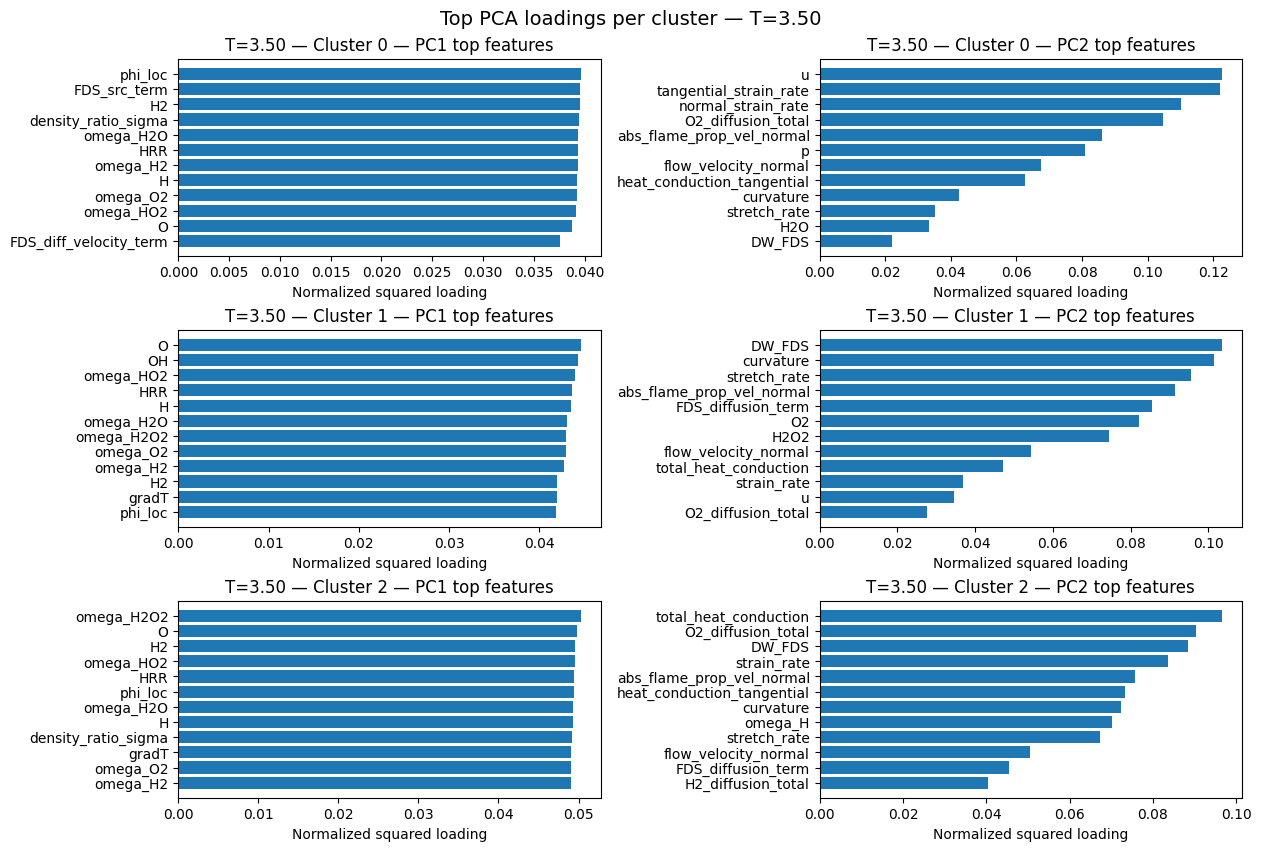

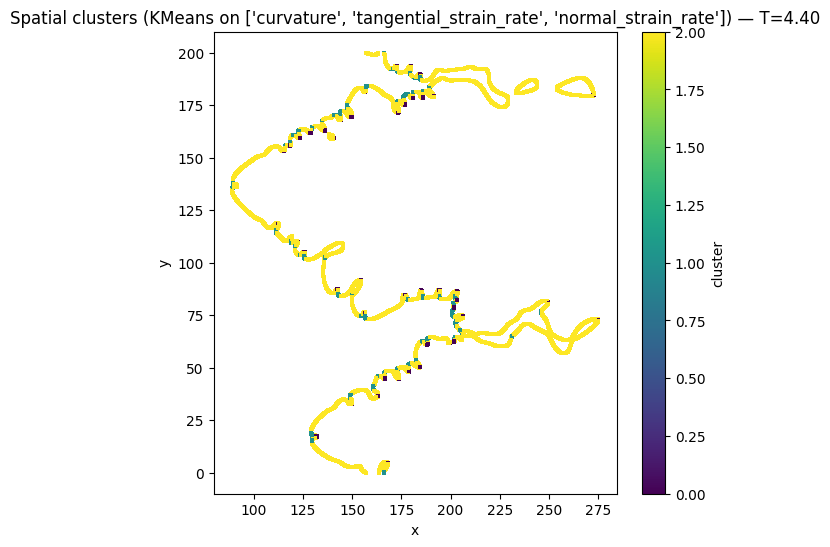

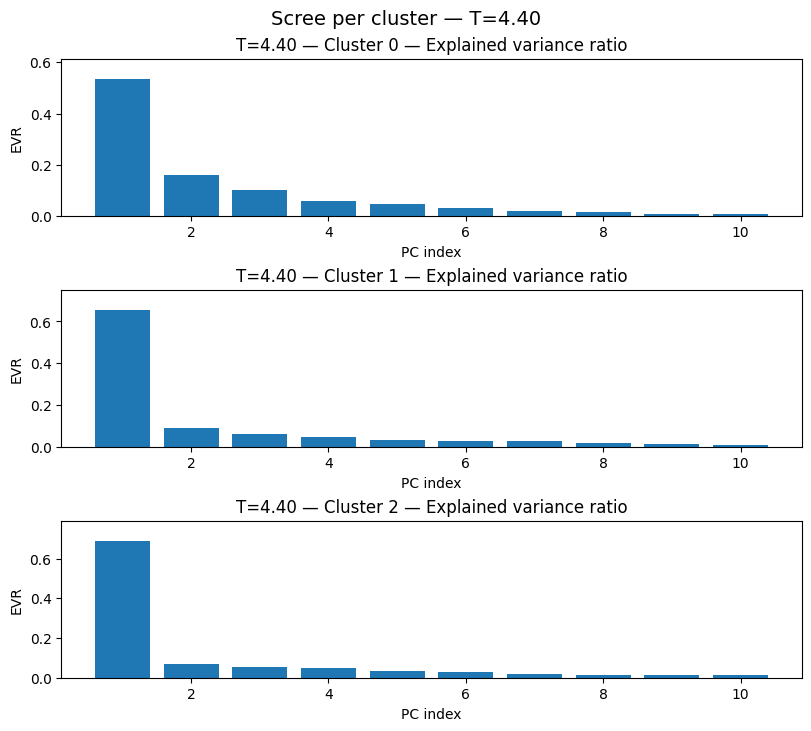

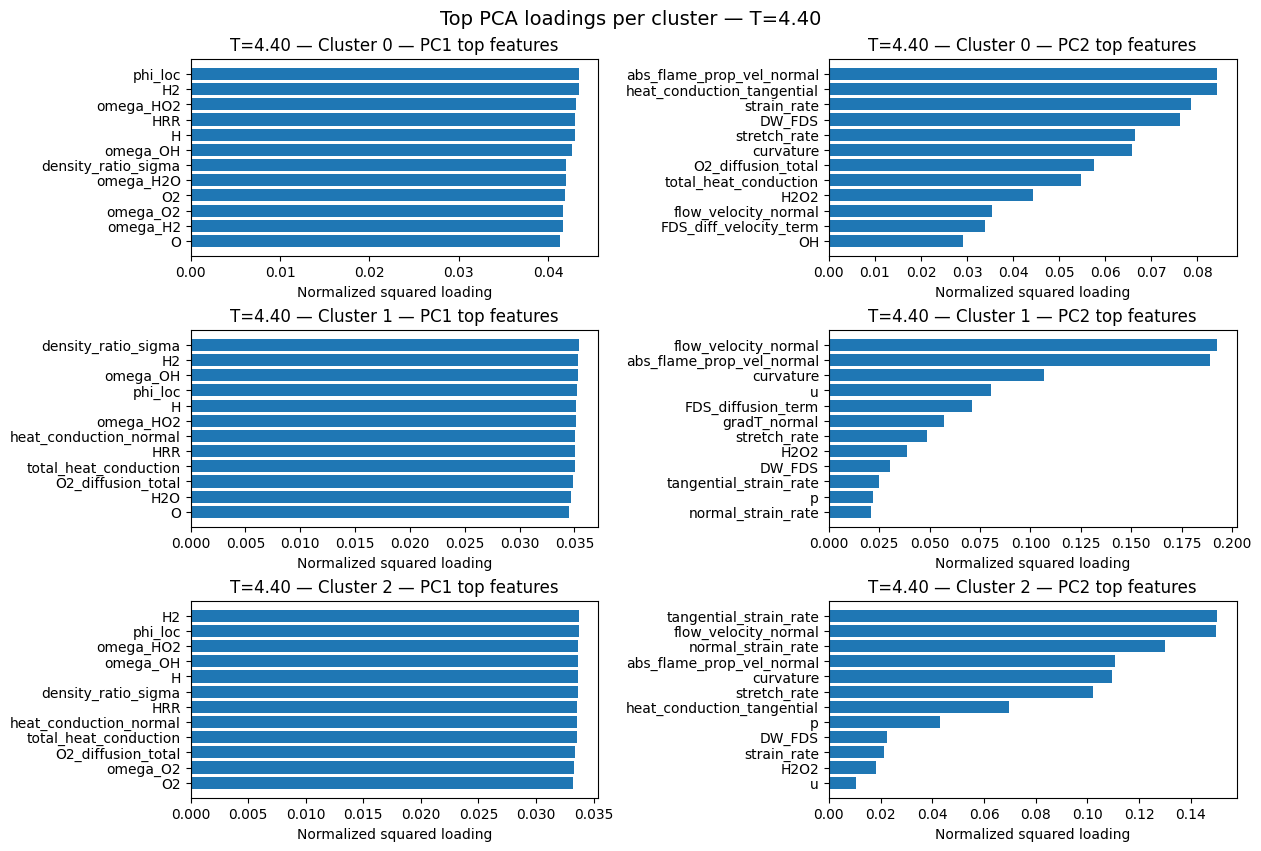

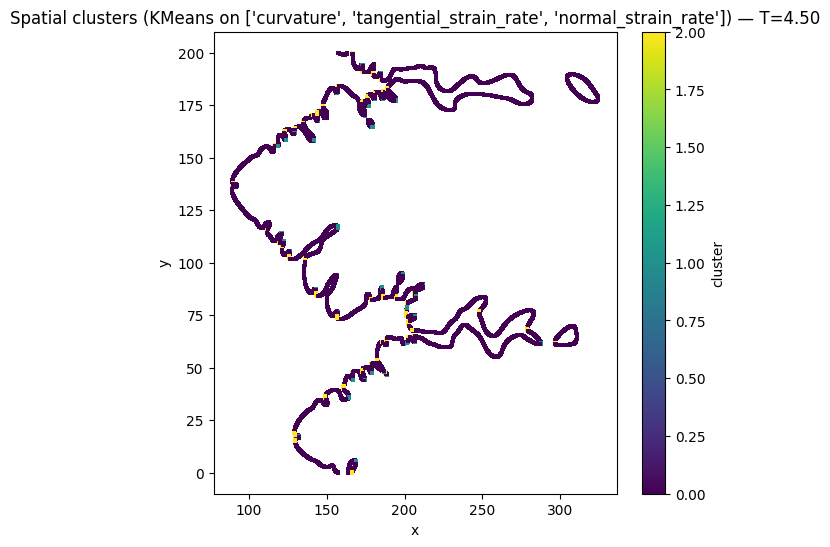

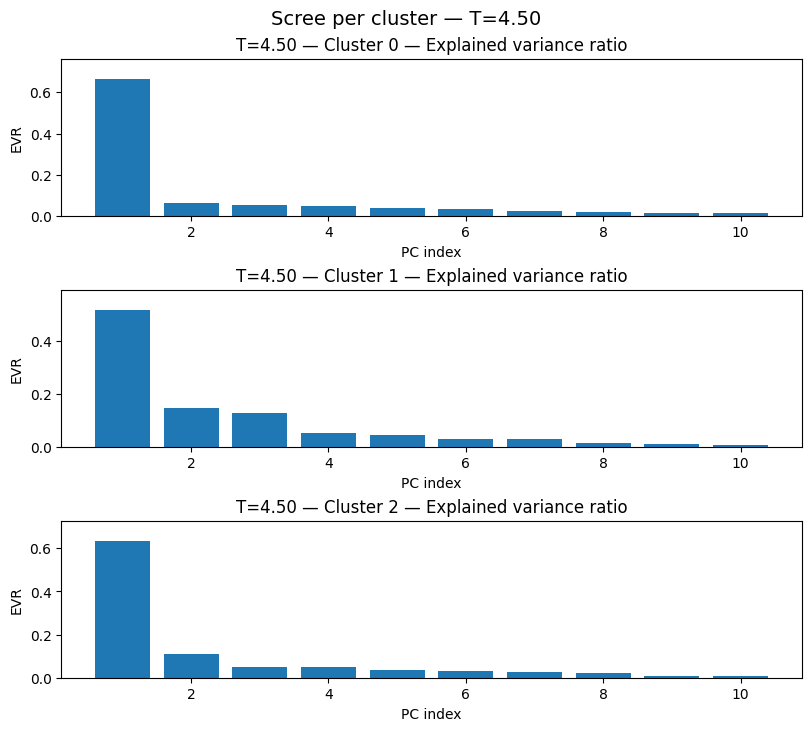

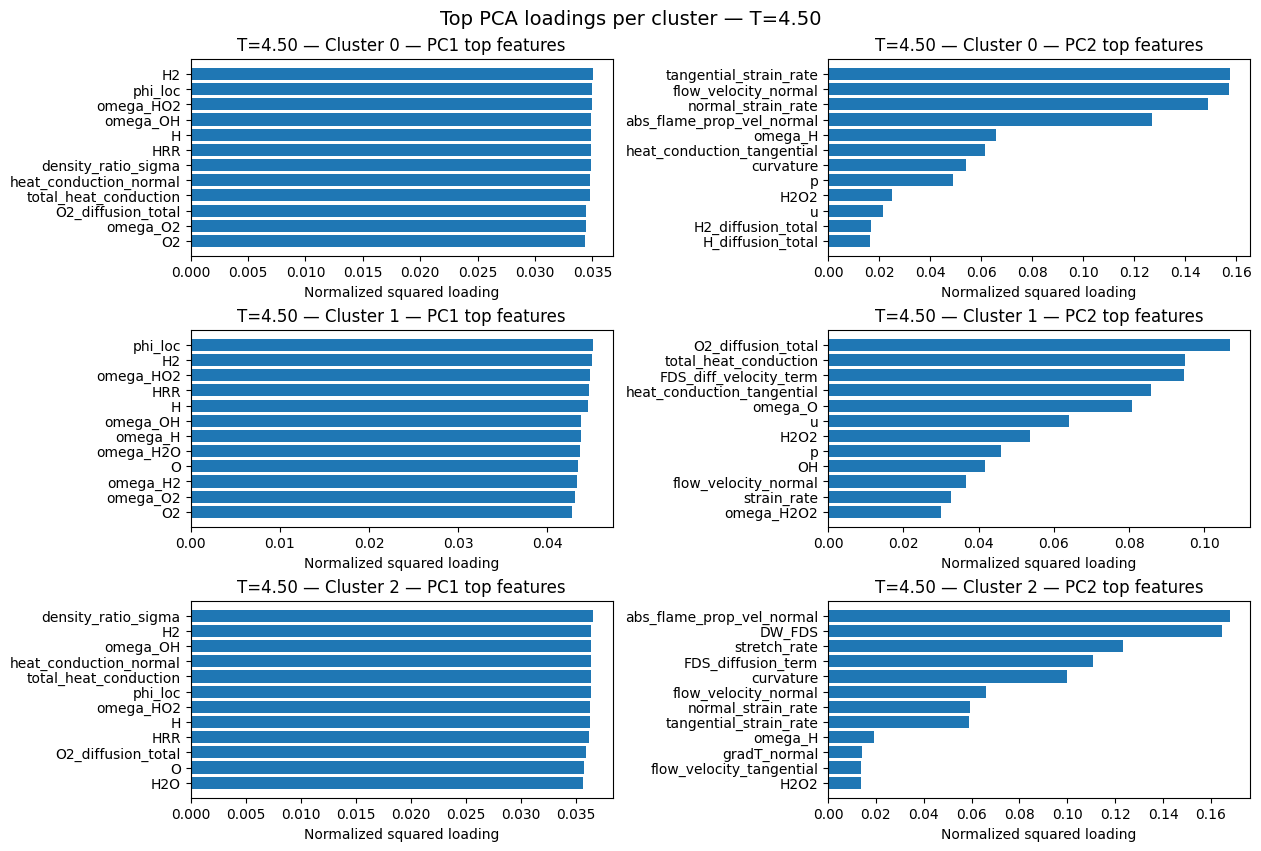

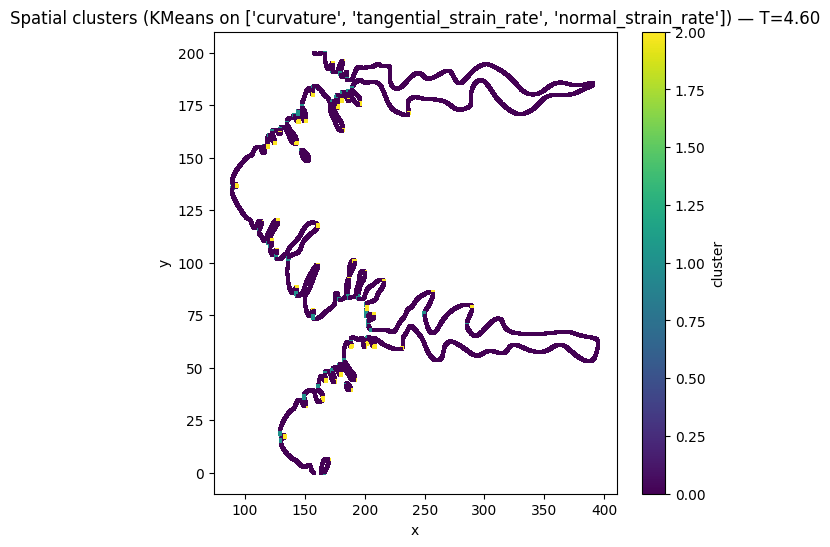

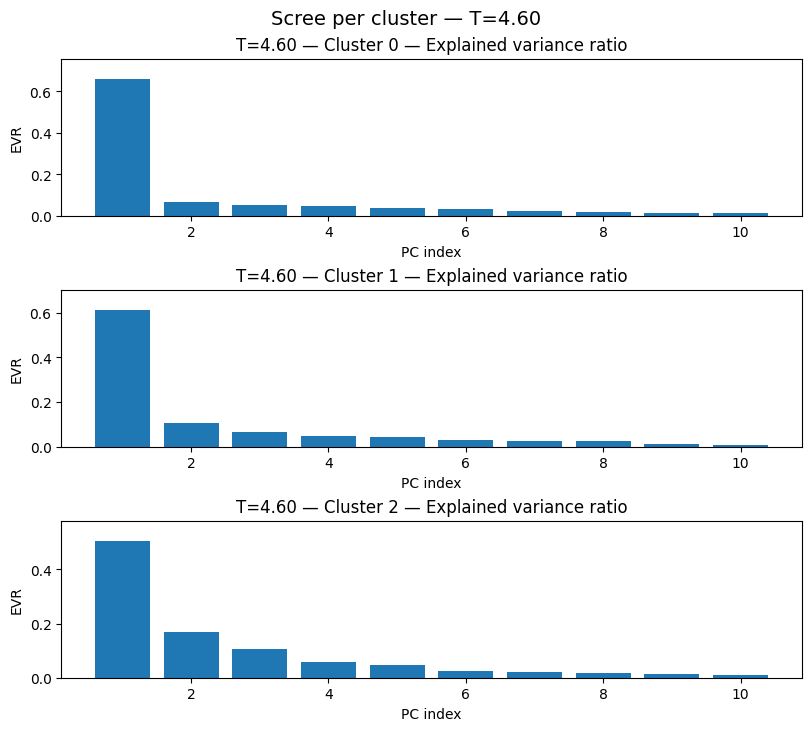

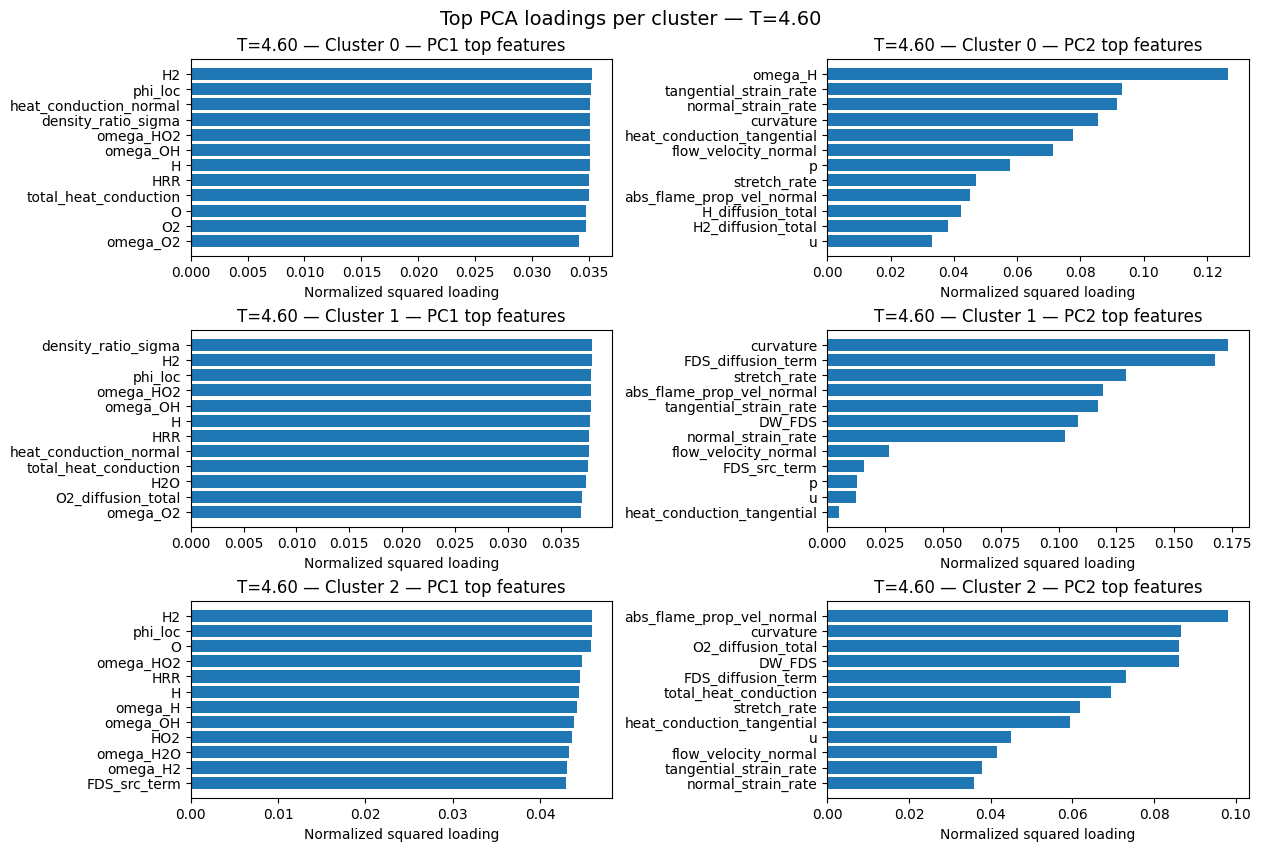

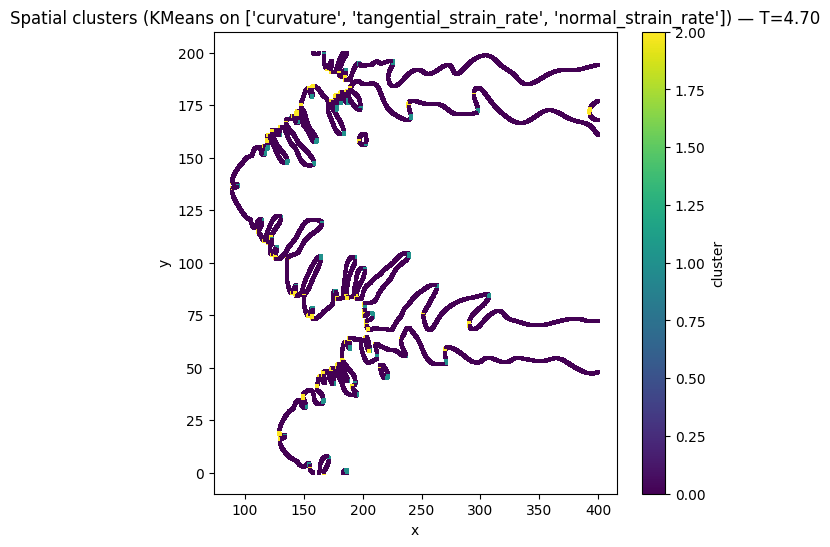

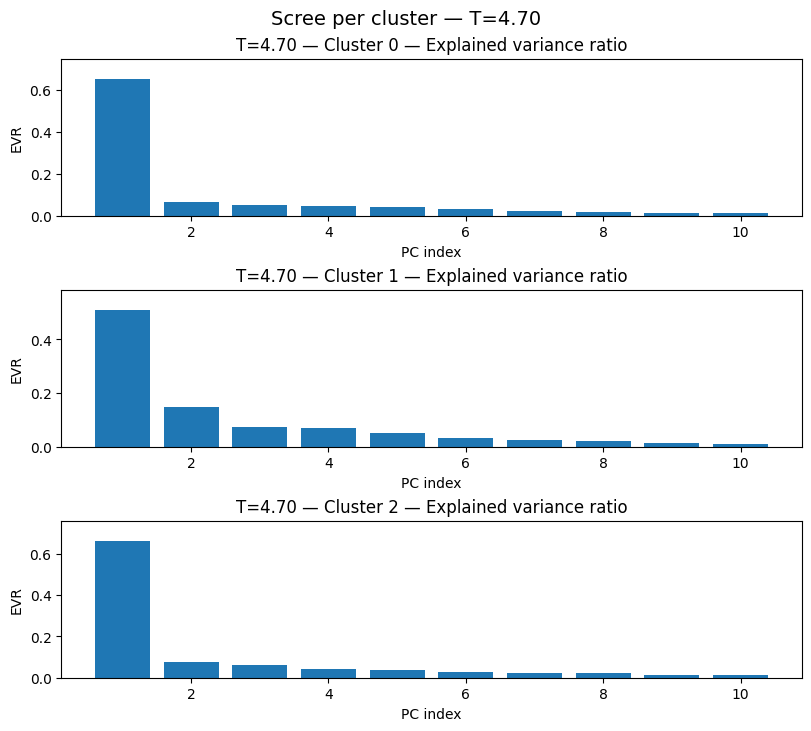

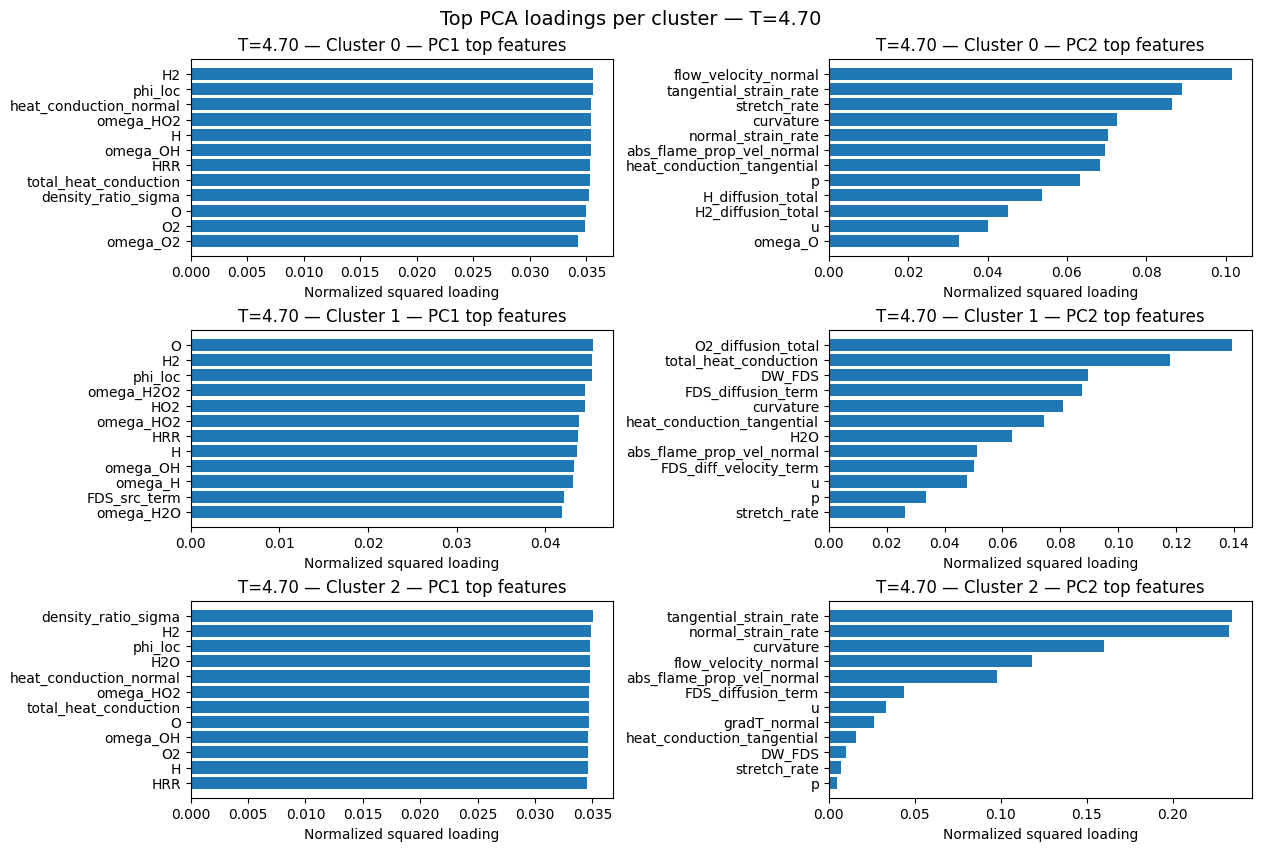

In [5]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from flamekit.io_fronts import Case, load_fronts

# ============================================================
# USER SETTINGS
# ============================================================
TIME_STEP = 230
PHI = 0.40
LAT_SIZE = "200"

ISOLEVELS = [3.0, 3.5, 4.4, 4.5, 4.6, 4.7]

BASE_DIR = Path("../data/isocontours")
POST = True

# If your Case supports these, set them here. If not, remove them.
MULTIPLE_RUNS = False
N_RUN = 2
SORET_TERM = False
SORET_POSITIVE = False

# ------------------------------------------------------------
# Clustering (multi-feature): curvature + tangential/normal strain
# ------------------------------------------------------------
N_CLUSTERS = 3
CLUSTER_FEATURES = ["curvature", "tangential_strain_rate", "normal_strain_rate"]

# Sd column (excluded from PCA by default)
SD_COL = "DW_FDS"

# PCA per cluster
MAX_PCS_TO_PLOT = 10
TOP_LOADINGS = 12
MIN_SAMPLES_PER_CLUSTER_PCA = 1

# ------------------------------------------------------------
# PCA VARIABLE CONTROL
# ------------------------------------------------------------
PCA_FEATURE_MODE = "auto"   # "explicit" or "auto"

PCA_FEATURES_EXPLICIT = [
    # e.g. "curvature", "stretch_rate", "HRR", "gradT", "gradT_normal"
]

EXCLUDE_FROM_PCA = {
    "c_iso",
    "x",
    "y",
    "z",
    "N2",
    "omega_N2",
}

PCA_STANDARDIZE = True

# ============================================================
# HELPERS
# ============================================================
def resolve_cluster_features(df: pd.DataFrame, requested: list[str]) -> list[str]:
    """
    Resolve clustering feature names, with a small typo-guard for 'strain_tagential'.
    """
    cols = df.columns
    resolved: list[str] = []
    for c in requested:
        if c in cols:
            resolved.append(c)
            continue
        # typo-guard: user sometimes has strain_tagential instead of strain_tangential
        if c == "strain_tangential" and "strain_tagential" in cols:
            resolved.append("strain_tagential")
            continue
        raise ValueError(
            f"Missing clustering feature '{c}' for clustering. "
            f"Example available columns: {list(cols[:30])}"
        )
    return resolved


def choose_pca_features(df: pd.DataFrame) -> list[str]:
    """
    Decide which variables PCA uses.
    - explicit: uses PCA_FEATURES_EXPLICIT
    - auto: uses all numeric columns except EXCLUDE_FROM_PCA
    """
    mode = PCA_FEATURE_MODE.lower().strip()
    if mode not in {"explicit", "auto"}:
        raise ValueError("PCA_FEATURE_MODE must be 'explicit' or 'auto'.")

    if mode == "explicit":
        if not PCA_FEATURES_EXPLICIT:
            raise ValueError(
                "PCA_FEATURE_MODE='explicit' but PCA_FEATURES_EXPLICIT is empty. "
                "Fill PCA_FEATURES_EXPLICIT with your desired PCA variables."
            )
        missing = [c for c in PCA_FEATURES_EXPLICIT if c not in df.columns]
        if missing:
            raise ValueError(f"PCA_FEATURES_EXPLICIT columns missing in dataframe: {missing}")
        return list(PCA_FEATURES_EXPLICIT)

    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    feats = [c for c in num_cols if c not in EXCLUDE_FROM_PCA]
    if len(feats) < 2:
        raise ValueError(f"Auto PCA features found {len(feats)} (<2). Adjust EXCLUDE_FROM_PCA.")
    return feats


def clean_numeric_matrix(df: pd.DataFrame, cols: list[str]) -> tuple[np.ndarray, list[str]]:
    X = df[cols].replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")
    return X.to_numpy(), cols


# ============================================================
# I/O: build Case + load fronts
# ============================================================
case = Case(
    base_dir=BASE_DIR,
    phi=PHI,
    lat_size=LAT_SIZE,
    time_step=TIME_STEP,
    post=POST,
)

# If your Case dataclass supports these optional fields, you can enable them:
try:
    case = Case(
        base_dir=BASE_DIR,
        phi=PHI,
        lat_size=LAT_SIZE,
        time_step=TIME_STEP,
        post=POST,
        multiple_runs=MULTIPLE_RUNS,
        n_run=N_RUN,
        soret_term=SORET_TERM,
        soret_positive=SORET_POSITIVE,
    )
except TypeError:
    pass

fronts = load_fronts(case, ISOLEVELS)

print(f"Loaded {len(fronts)} fronts from: {BASE_DIR}")
print(f"Isolevels: {list(fronts.keys())}")
print(f"KMeans: {N_CLUSTERS} on {CLUSTER_FEATURES}")
print(f"PCA mode: {PCA_FEATURE_MODE}")
if PCA_FEATURE_MODE == "explicit":
    print(f"PCA features (explicit): {PCA_FEATURES_EXPLICIT}")
else:
    print(f"PCA excluded (auto): {EXCLUDE_FROM_PCA}")


# ============================================================
# RUN: clustering + PCA per cluster
# ============================================================
clustered_fronts: dict[float, pd.DataFrame] = {}

for c_val, front in fronts.items():
    front = front.copy()

    # Required columns for plotting
    for col in ["x", "y"]:
        if col not in front.columns:
            raise ValueError(f"ISO {c_val}: missing required column '{col}'.")

    # Resolve clustering columns (handles strain_tagential typo)
    cluster_cols = resolve_cluster_features(front, CLUSTER_FEATURES)

    # (A) KMeans on curvature + tangential/normal strain
    pipe_cluster = make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        KMeans(
            n_clusters=N_CLUSTERS,
            init="k-means++",
            n_init=20,
            max_iter=300,
            random_state=0,
        ),
    )

    labels = pipe_cluster.fit_predict(front[cluster_cols].to_numpy())
    front["cluster"] = labels
    clustered_fronts[float(c_val)] = front

    # Spatial plot
    plt.figure(figsize=(6.5, 6.0))
    plt.scatter(front["x"], front["y"], c=front["cluster"], s=8, marker="s", linewidths=0)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Spatial clusters (KMeans on {cluster_cols}) — T={float(c_val):.2f}")
    plt.colorbar(label="cluster")
    plt.show()

    # (B) PCA inside each cluster
    pca_feats = choose_pca_features(front)
    present_clusters = sorted(front["cluster"].unique().tolist())
    if not present_clusters:
        continue

    nrows = len(present_clusters)

    fig_scree, axs_scree = plt.subplots(
        nrows=nrows, ncols=1,
        figsize=(8.0, 2.4 * nrows),
        constrained_layout=True,
        squeeze=False,
    )
    fig_load, axs_load = plt.subplots(
        nrows=nrows, ncols=2,
        figsize=(12.5, 2.8 * nrows),
        constrained_layout=True,
        squeeze=False,
    )

    for i, k in enumerate(present_clusters):
        dfk = front[front["cluster"] == k]

        if len(dfk) < MIN_SAMPLES_PER_CLUSTER_PCA:
            axs_scree[i, 0].axis("off")
            axs_load[i, 0].axis("off")
            axs_load[i, 1].axis("off")
            axs_scree[i, 0].text(
                0.01, 0.5,
                f"Cluster {k}: skipped (n={len(dfk)} < {MIN_SAMPLES_PER_CLUSTER_PCA})",
                va="center",
                fontsize=10,
            )
            continue

        Xk, feats_used = clean_numeric_matrix(dfk, pca_feats)

        if Xk.shape[0] < MIN_SAMPLES_PER_CLUSTER_PCA:
            axs_scree[i, 0].axis("off")
            axs_load[i, 0].axis("off")
            axs_load[i, 1].axis("off")
            axs_scree[i, 0].text(
                0.01, 0.5,
                f"Cluster {k}: skipped after NaN/inf drop (n={Xk.shape[0]})",
                va="center",
                fontsize=10,
            )
            continue

        Xs = StandardScaler().fit_transform(Xk) if PCA_STANDARDIZE else Xk

        n_pcs_fit = min(Xs.shape[1], MAX_PCS_TO_PLOT)
        pca = PCA(n_components=n_pcs_fit, random_state=0).fit(Xs)

        evr = pca.explained_variance_ratio_
        idx = np.arange(1, len(evr) + 1)

        # Scree
        ax = axs_scree[i, 0]
        ax.bar(idx, evr)
        ax.set_title(f"T={float(c_val):.2f} — Cluster {k} — Explained variance ratio")
        ax.set_xlabel("PC index")
        ax.set_ylabel("EVR")
        ax.set_ylim(0, max(0.05, float(np.max(evr)) * 1.15))

        # Top loadings for PC1/PC2
        comps = pca.components_
        feats_arr = np.array(feats_used)

        def plot_pc_contrib(ax_, pc_idx: int, title: str):
            if pc_idx >= comps.shape[0]:
                ax_.axis("off")
                ax_.text(0.01, 0.5, f"{title}: not available", va="center", fontsize=10)
                return

            load = comps[pc_idx, :]
            contrib = load ** 2
            s = contrib.sum()
            if s > 0:
                contrib = contrib / s

            order = np.argsort(contrib)[::-1][:TOP_LOADINGS]
            top_feats = feats_arr[order][::-1]
            top_vals = contrib[order][::-1]

            ax_.barh(top_feats, top_vals)
            ax_.set_title(title)
            ax_.set_xlabel("Normalized squared loading")

        plot_pc_contrib(
            axs_load[i, 0],
            pc_idx=0,
            title=f"T={float(c_val):.2f} — Cluster {k} — PC1 top features",
        )
        plot_pc_contrib(
            axs_load[i, 1],
            pc_idx=1,
            title=f"T={float(c_val):.2f} — Cluster {k} — PC2 top features",
        )

    fig_scree.suptitle(f"Scree per cluster — T={float(c_val):.2f}", fontsize=14)
    fig_load.suptitle(f"Top PCA loadings per cluster — T={float(c_val):.2f}", fontsize=14)
    plt.show()

# `clustered_fronts` is ready for Block 2 (prediction + permutation importance).
